# Analyzing interesting points in San Francisco ( House price, crime, vendor etc)

In 2017 spring quater, I took a course called `interactive data visualization with Web technology`, there is one homework which give us a lot of open dataset related to San Francisco, including crime, mobile food trucks, house price and so on.

This assignment need me to find out interesting point by myself, so I went into it and mine exist data which give me a lot of fun discoveries.

# Dataset Discription


In this project, I,ll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).


# Key findings:

* mobile food vendor(s) called `The M M Catering` with permit `17MFF-0109` sells at the most locations
* In San Francisco, the area with zipecode 94124 which seems to be Bayview district has least price.The highest house price area has zipcode 94158 which seems to be Misson Bay.
* The most criminal region in San Francisco are Downtown/Union Square and Tenderloin, within time range from 15:00 to 19:00.
* Most of the construction noise complained happened at the northeast of San Francisco. What's more, northeast of San Francisco have more music related noise complain, especially the road called Mission Street.
* The best place and time to find a food truck is at 1 SANSOME Street, SUTTER Street to BUSH Street (1 - 99), from 11:00am to 15:00pm. 
* The number of parks and house price are negtive related, the parking lot number are positive related to house price. However, there are negtive relation between school number and house price. Surprisingly, crime number seems to be positive related to house price.

In [1]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sqlalchemy as sqla
import sqlite3
%matplotlib inline
plt.style.use('ggplot')
from descartes import PolygonPatch
import matplotlib.cm as cm
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from itertools import chain
import fiona

__Question 1.1.__ Which mobile food vendor(s) sells at the most locations?

**Answer**:The <strong style="color: red;">M M Catering</strong> with permit <strong style="color: red;">17MFF-0109</strong> has the most locations which is <strong style="color: red;">20</strong>.

In [2]:
#read in sqlite file
sqlite_file = 'sf_data.sqlite'
sfdata = sqla.create_engine('sqlite:///' + sqlite_file)

Grouping by locationid and count the number for each group, we can find out the permit number which sells at the most locations.

In [3]:
sql_query = """
select permit, count(*) as count from mobile_food_schedule
group by "locationid"
order by "count" desc
"""
location = pd.read_sql_query(sql_query,sfdata)
location[:1]

,permit,count
0,17MFF-0109,20


Extract the truck which have permit number 17MFF-0109 in mobile_food_permits table, we can get the information about this food vendor truck.

In [4]:
sql_query = """
select * from mobile_food_permits
where "permit"="17MFF-0109"
"""
vendor = pd.read_sql_query(sql_query,sfdata)
vendor

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,17MFF-0109,REQUESTED,M M Catering,Truck,Cold Truck: sandwiches: corndogs: tacos: yogur...,1,None,2018-03-31 12:00:00


__Question 1.2.__ 

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* What's the distribution of certain kinds of noise complain?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

__Anwser 1.2.1__ In order to find the most and least expensive house price, I firstly get all price data from zillow which is sql form. Then, I group by region name and find the average median sold price per square feet for each area. After that, I read the US and SF shapefile. I can use zipcode, in US shapefile, as index to find the polygon area for max and min price area. For SF shapefile, I use it as map base, and draw max price area as red and min price area as blue. The answer shows that the area with zipecode **94124** which seems to be **Bayview district** has least price. I believe this happened because this area don't have popular view points. The northeast of San Francisco is the most prosperous downtown, the northwest have Golden Gate Park and Golden Gate Bridge, both of which are famous view points, and for southwest, there is Lake Merced Park which is good place to live in, so only the southeast area have nothing. The highest house price area has zipcode **94158** which seems to be **Misson Bay**. This area is close to downtown which means close to work place and bussiness center, both of which might cause the highest price.

Read house price data from zillow in SQL, then extract the max price and minimal price.

In [5]:
#get sql data of house price 
sql_query = """
select * from zillow
"""
price = pd.read_sql_query(sql_query,sfdata)
cal_price = price.dropna(axis=0).groupby('RegionName').mean().iloc[:,1].sort_values()
#find the max and min price
min_price_value = cal_price.index[0]
max_price_value = cal_price.index[-1]

By using `geopandas`, I can read shapefile as pandas Dataframe, which is easy to operate and analyse.

In [6]:
import geopandas as gpd
zips = gpd.read_file("cb_2015_us_zcta510_500k.shp")
zip2 = gpd.read_file("geo_export_2e252477-b935-40be-bff1-1d301a6f329c.shp")

Extract the polygon data for the area with max house price and minimal house price, which can be located with zipcode provided by zillow dataset.

In [7]:
#get the polygon file of max and min price
min_price = zips[zips['ZCTA5CE10']==str(min_price_value)]
max_price = zips[zips['ZCTA5CE10']==str(max_price_value)]
maxmin_price = min_price.append(max_price)
maxmin_price

,AFFGEOID10,ALAND10,AWATER10,GEOID10,ZCTA5CE10,geometry
32085,8600000US94124,12759665,2806581,94124,94124,"POLYGON ((-122.407752 37.740585, -122.404819 3..."
5156,8600000US94158,1703879,1342698,94158,94158,"POLYGON ((-122.397866 37.772323, -122.396381 3..."


Read san francisco shapefile and draw it as plot base, then draw maximum house price area as red minimum house price area as blue.

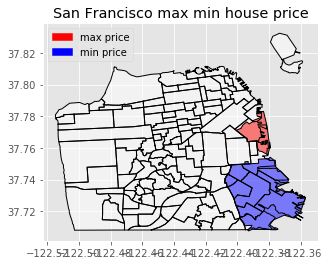

In [8]:
import matplotlib.patches as mpatches
base = zip2.plot(color='w')
max_price.plot(ax = base,color='red')
min_price.plot(ax = base,color='blue')
plt.title('San Francisco max min house price')
red_patch = mpatches.Patch(color='red', label='max price')
blue_patch = mpatches.Patch(color='blue', label='min price')
plt.legend(handles=[red_patch,blue_patch])

__Answer 1.2.2__ In order to find Which parts of the city are the most dangerous (and at what times). Firstly, I extract all the crime data in 2015, otherwist it's too large to operate. I firstly group data by category, and change the lon and lat data to points which can be used to plot. Then I find the most common five crime, and use it to draw scatter plot. It shows that the occurance of warrant concentrate in the northeast of San Francisco which is the most prosperous area. For other crimes like assault and theft happened all over San Francisco. Then I calculate the number of crime happened in each polygon area, and get the crime density, which can be used to draw heat map. The first view of heat map show that the closer to the the downtown area the more crime might happened. The most criminal region in San Francisco are **Downtown/Union Square and Tenderloin**, by checking on google I find that both of them locate in Tenderloin District, so I find all crime happened in this area and group by hour. After that, by counting the number of crime incidence, it shows that time  range from **15:00 to 19:00** is the most dangerous. I believe the reason is this area is downtown area, most people shopping at the duration, which means crimes like theft will happen at that time too.

Using `fiona` to read shapefile is better for later processing. Then I do some pre-processing in order for latter data operation:
* Map boundaries: used to define what to display.
* Width, height: used to center the plot.

In [9]:
# Extract map boundaries
shp = fiona.open('geo_export_2e252477-b935-40be-bff1-1d301a6f329c.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

With boundaries we can creat `matplotlib Basemap` object, which is the foundation of our map.

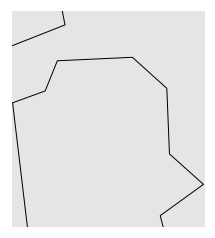

In [10]:
#use basemap to set area and read shapefile
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'geo_export_2e252477-b935-40be-bff1-1d301a6f329c',
    'SF',
    color='none',
    zorder=2)
m.drawcoastlines()

### Draw scatter plot for top 5 criminal 

I extract all the crime data I need, since the original one is too large, so I just analysis the top 5 crime in San Francisco in 2015.

In [11]:
sql_query = """
select Category, count(*) as count from crime
group by "Category"
order by count DESC
"""
#find the top 5 crime category and remove non-criminal
crime_num = pd.read_sql_query(sql_query,sfdata)
top_5_crime=list(crime_num['Category'].values)[:6]
top_5_crime.remove('NON-CRIMINAL')
top_5_crime

['LARCENY/THEFT', 'OTHER OFFENSES', 'ASSAULT', 'VANDALISM', 'WARRANTS']

In [12]:
sql_query = """
select * from crime
"""
crime = pd.read_sql_query(sql_query,sfdata)
#use Datetime method to find the hour of each crime incident
crime["Datetime"] = pd.to_datetime(crime["Datetime"], format="%Y-%m-%d %H:%M:%S")
crime["Hour"] = crime.Datetime.apply(lambda x: x.hour)
crime["Year"] = crime.Datetime.apply(lambda x: x.year)
#original file is too large, focusing crime in 2015
crime_15=crime[crime['Year']==2015]
crime_15.head()

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat,Hour,Year
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,14,2015
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,15,2015
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,15,2015
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,15,2015
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,19,2015


In [13]:
#use cm to give different category different colors
import matplotlib.cm as cm
import numpy as np
x = np.arange(5)
ys = [i+x+(i*x)**2 for i in range(5)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))

Since I need some data to draw scatter point, I use crime dataset DataFrame and convert the Longitude and Latitude columns to `shapely Point` and `MultiPoint` which will be the basis for drawing on our Basemap.

In [14]:
def makePoints(dat):
    '''
    Create Point objects in map coordinates from dataframe lon and lat values
    input: DataFrame with longitude and Latitude value
    output: points
    '''
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(dat['Lon'],dat['Lat'])])
    plt_points = MultiPoint(list(map_points.values))
    return plt_points

Next I want to create a DataFrame representing our map data on which I can apply operations. This DataFrame will contains Polygon objects via `shapely` where each `Polygon` represents a San Francisco neighborhood.
In this DataFrame I also want to include geographic information like the area size in meters and kilometers, because ultimately I will represent the crime density by neighborhood.

In [15]:
#extract information from shapefile
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
#calculate area needed for later
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))
#show 5 sample from dataframe
df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches
50,"POLYGON ((8335.076692032308 7787.299476731984,...",Mission,3.115872e+06,31.158725,"Poly((8335.08, 7787.3) ...)"
90,"POLYGON ((7527.326043200221 3224.86163999004, ...",Mission Terrace,1.274966e+06,12.749661,"Poly((7527.33, 3224.86) ...)"
78,"POLYGON ((4758.09810016532 2040.057678075535, ...",Oceanview,1.010984e+06,10.109838,"Poly((4758.1, 2040.06) ...)"
111,"POLYGON ((6363.126487203263 7525.407913555177,...",Buena Vista,6.796955e+05,6.796955,"Poly((6363.13, 7525.41) ...)"
11,"POLYGON ((6146.428815668049 9192.726834578978,...",Lone Mountain,8.134841e+05,8.134841,"Poly((6146.43, 9192.73) ...)"


With `Basemap` as map base, SF shapefile overlay and `Points` for different crime, I can draw the scatter plot for different crime. I draw the top 5 crime, `LARCENY/THEFT, OTHER OFFENSES, ASSAULT, VANDALISM, WARRANTS`, with different color.It shows that the occurance of warrant concentrate in the northeast of San Francisco which is the most prosperous area. For other crimes like assault and theft happened all over San Francisco. 

D:\anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for mo

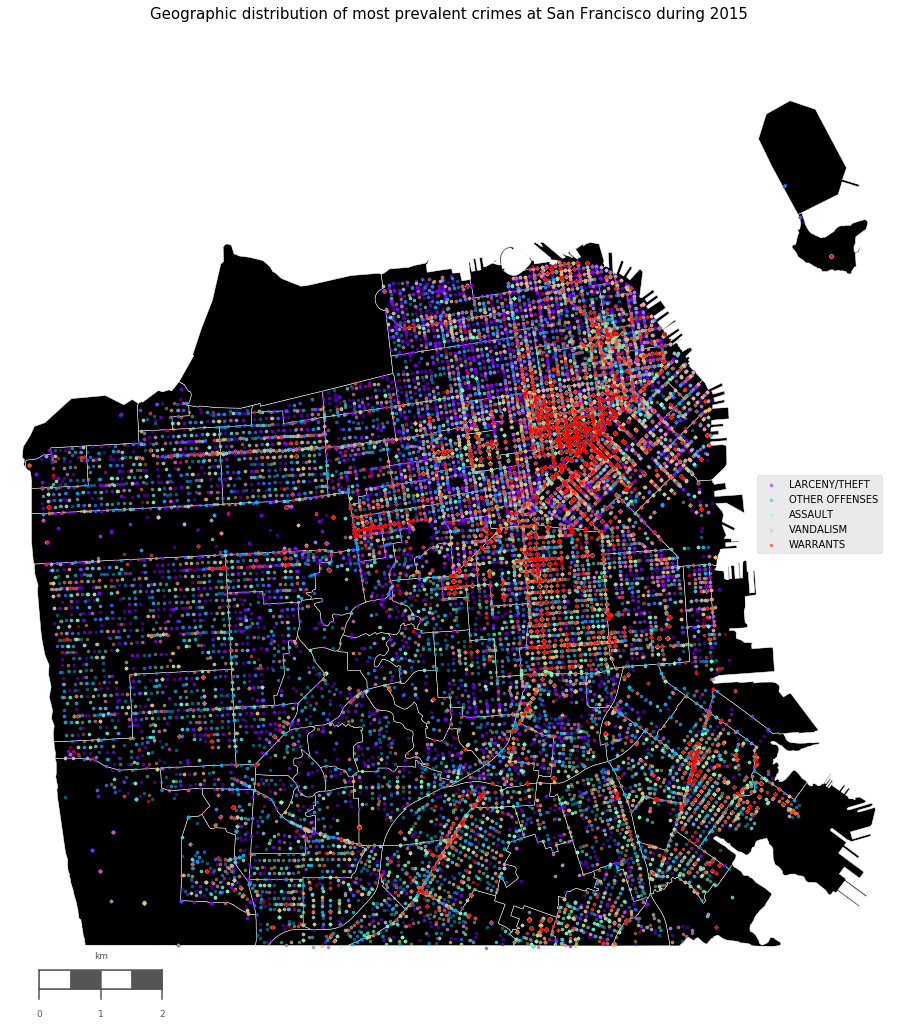

In [16]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# Scatter top 5 crime occurance location
for i in range(len(top_5_crime)):
    j=makePoints(crime_15[crime_15["Category"]==top_5_crime[i]])
    dev = m.scatter(
    [geom.x for geom in j],
    [geom.y for geom in j],
    10, marker='o', lw=.25,
    facecolor=colors[i], edgecolor=colors[i],
    alpha=0.5, antialiased=True,
    label=top_5_crime[i], zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of most prevalent crimes at San Francisco during 2015", size=15)
fig.set_size_inches(15,15)
plt.show()

### Draw heat map of crime number for different area

Crime heat map is a good way to visualize the density of crime. With previous operation, I already get the `polygon` for each San Francisco neighbour, so I count the number of crime happened in each `polygon` area. With the area calcualted before, I can calculate the crime density for each neighbour.

Then, I use a classification algorithm called [Jenks Natural Breaks Optimization](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization) which will take all our neighborhoods and their crime densities, and divide these into several crime categories.

In [17]:
#count the number of crime happened in each polygon area
sf_15_crimes_points=makePoints(crime_15)
df_map['count'] = df_map['poly'].map(lambda x: int( len(list(filter(prep(x).contains, sf_15_crimes_points)))))
#calculate the density of crime in each area
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches,count,density_m,density_km
68,"POLYGON ((5219.630039982891 4601.760326036463,...",Miraloma Park,9.658742e+05,9.658742,"Poly((5219.63, 4601.76) ...)",315,0.000326,32.612942
40,"POLYGON ((3110.712006055903 3100.38269569234, ...",Parkmerced,1.260732e+06,12.607318,"Poly((3110.71, 3100.38) ...)",866,0.000687,68.690264
62,"POLYGON ((5489.843571657766 962.0397298898873,...",Outer Mission,7.836756e+05,7.836756,"Poly((5489.84, 962.04) ...)",491,0.000627,62.653474
61,"POLYGON ((3885.8727735383 2037.279949430944, 4...",Merced Heights,7.584046e+05,7.584046,"Poly((3885.87, 2037.28) ...)",509,0.000671,67.114572
83,"POLYGON ((10113.32894155972 3127.657208697576,...",Bayview,2.578234e+06,25.782339,"Poly((10113.3, 3127.66) ...)",4068,0.001578,157.782427


Next I use `PySAL` which has an implementation of the Natural Breaks algorithm, and apply it to the crime density per square kilometer, and ask the algorithm to divide the neighborhoods in 5 classes.

In [18]:
from pysal.esda.mapclassify import Natural_Breaks as nb

# divide the neighborhoods in 5 classe according to density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)

prev = 0
for density, counts in zip(breaks.bins, breaks.counts):
    print ("%d neighborhoods have crime density D such as %d/km^2 <= D <= %d/km^2" % (counts, prev, density))
    prev = density

60 neighborhoods have crime density D such as 0/km^2 <= D <= 90/km^2
31 neighborhoods have crime density D such as 90/km^2 <= D <= 228/km^2
18 neighborhoods have crime density D such as 228/km^2 <= D <= 424/km^2
5 neighborhoods have crime density D such as 424/km^2 <= D <= 853/km^2
2 neighborhoods have crime density D such as 853/km^2 <= D <= 1866/km^2


From that, I join back the results of the Natural Breaks algorithm with my map DataFrame so that I know for each neighborhood what its class is. This is all I need in terms of data, based on that I will be able to assign different colors to each neighborhood based on their class.

I also want to create the labels for the color scale based on the density values found by the algorithm, so we can show in the map to what density each color corresponds.

In [19]:
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map.drop("jenks_bins", inplace=True, axis=1, errors="ignore")
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# assign labels to the colorbar based on the natural breaks bins
jenks_labels = ["<= %0.1f crimes / km$^2$" % b for b in breaks.bins]
jenks_labels.insert(0, 'No crimes')

For now, I have all I want, so I just draw the heat map for each crime density. The darker blue means higher crime density. In addition, with the help of neighbour map which I got from google, I can clearly concluse which area is more dangerous.

D:\anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\anaconda\lib\site-packages\ipykernel\__main__.py:45: FutureWarning: sort(....) is deprecated, use sort_index(.....)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


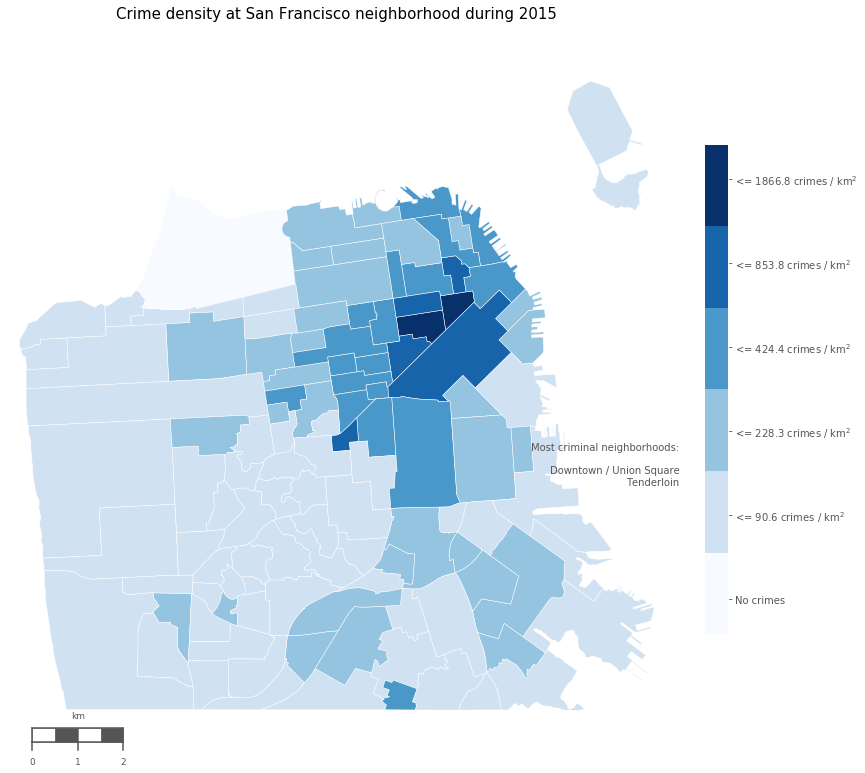

In [20]:
from matplotlib.colors import Normalize, LinearSegmentedColormap 

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# use a blue colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Blues')
pc = PatchCollection(df_map['patches'], match_original=True)
# impose our colour map onto the patch collection
norm = Normalize()
pc.set_facecolor(cmap(norm(df_map['jenks_bins'].values)))
ax.add_collection(pc)

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N + 1)]
    return LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

# Add a colour bar
cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
cb.ax.tick_params(labelsize=10)

# Show highest densities, in descending order
highest = '\n'.join(
    value[1] for _, value in df_map[(df_map['jenks_bins'] == 4)][:10].sort().iterrows())
highest = 'Most criminal neighborhoods:\n\n' + highest
# Subtraction is necessary for precise y coordinate alignment
details = cb.ax.text(
    -1., 0 + 0.3,
    highest,
    ha='right', va='bottom',
    size=10,
    color='#555555')

# Draw a map scale
m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)
plt.tight_layout()
plt.title("Crime density at San Francisco neighborhood during 2015", size=15)
fig.set_size_inches(15, 15)
plt.show()

<img width=400 src="http://www.sfhomeblog.com/wp-content/uploads/2015/07/SF_Districts_color_neighborhoods-2012.jpg"><br>

With heat map, I locate the most dangerous neighbour with the higheast crime density. After that, the only thing I need to do is to find the most dangerous time range.

In [21]:
#find the most dangerous area
df_map[(df_map['jenks_bins'] == 4)][:10]

,poly,ward_name,area_m,area_km,patches,count,density_m,density_km,jenks_bins
17,"POLYGON ((10105.91645719224 10121.59139921073,...",Downtown / Union Square,359887.139956,3.598871,"Poly((10105.9, 10121.6) ...)",5878,0.016333,1633.289814,4.0
18,"POLYGON ((9444.007474893049 9700.523427991458,...",Tenderloin,534714.272619,5.347143,"Poly((9444.01, 9700.52) ...)",9982,0.018668,1866.791390,4.0


The most dangerous area is Downtown/Union Square and Tenderloin, both belong to Tenderloin District, so I tried to find the crime number of at this district in different time.

In [22]:
#find the crime happened at Tenderloin
crime_15_dangerous=crime_15[crime_15['PdDistrict']=='TENDERLOIN']
crime_15_dangerous.head()

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat,Hour,Year
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,15,2015
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,15,2015
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,15,2015
24,150098420,ROBBERY,ATTEMPTED ROBBERY WITH A DEADLY WEAPON,Sunday,2015-02-01 17:10:00,TENDERLOIN,"ARREST, BOOKED",400 Block of ELLIS ST,-122.413609,37.784697,17,2015
25,150098420,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 17:10:00,TENDERLOIN,"ARREST, BOOKED",400 Block of ELLIS ST,-122.413609,37.784697,17,2015


By counting the number of crime happened at different hour, sorting by descending order, I find the crime peak will be reached within time range from 15:00--19:00.

In [23]:
#find the crime number at different hour and sort by decreasing method
dangerous=crime_15_dangerous.groupby('Hour').count().iloc[:,0]
time=np.argsort(-dangerous,)
dangerous[time]

IncidntNum
15    716
18    708
16    696
17    676
12    637
14    601
19    587
20    547
0     526
13    513
22    512
21    483
23    465
11    452
10    404
9     393
8     347
1     338
2     251
7     248
3     183
6     179
5     152
4     121
Name: IncidntNum, dtype: int64

__Exercise 1.2.3__ In this question I want to find the distribution of two types of noise complain, one is the construction related noise. Firstly, I find all the noise type which contain word construciton, and the answer shows there are four kinds of construction related noise:
* construction_public
* construction_emergency
* delivery_service_construction
* construction_private_property

Then I extrct these types of noises and use the makepoint function defined before to change longitude and latitude data into points. Then I draw the scatter plot of all the construction related noise on San Francisco map, it shows that most of the construction noise complained happened at the northeast of San Francisco. This area is the downtown area, so many human activities happened in there, and the communal facilities might worn out quickly, which might cause a lot of public construction. Since many people live in this area too, private constructions are active. On the other hand, I also draw the music related scatter plot, which might come from parties. This group of noise contain two kinds.
* amplified sound electricity
* entertainment

I draw the scatter plot which shows that northeast of San Francisco have more music related noise complain which make sense since there are so many people live or work in this area. However, there is one specific road line shows that music noise is very high. I check the wikipedia and find this road is called [Mission Street](https://en.wikipedia.org/wiki/Mission_District,_San_Francisco), where rich in musical groups and performances, and explain this phenomenon perfectly.

Get noise from SQL, then extract all noise type which contain key words **construction**.

In [24]:
sql_query = """
select * from noise
"""
noise = pd.read_sql_query(sql_query,sfdata)
noise = noise.dropna()
construction_noise = noise[noise.Type.str.contains('construction')]
construction_type = list(set(construction_noise['Type'].values))
construction_noise.head()

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087
7,5661981,construction_public,"1275 COLUMBUS AVE, SAN FRANCISCO, CA, 94133",Fisherman's Wharf,2016-03-14 08:09:25,37.805616,-122.418177
19,6470436,construction_private_property,Intersection of GRANT AVE and LOMBARD ST,North Beach,2016-10-28 10:24:58,37.803433,-122.408146
20,5657665,construction_private_property,"3580 CALIFORNIA ST, SAN FRANCISCO, CA, 94118",Presidio Heights,2016-03-11 23:34:39,37.786606,-122.452955
21,5623912,construction_private_property,"994 OSHAUGHNESSY BLVD, SAN FRANCISCO, CA, 94131",Miraloma Park,2016-03-02 17:12:20,37.735790,-122.442276


Use the necessary plot needed files got before, and draw the scatter plot of construction related noise.

D:\anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for mo

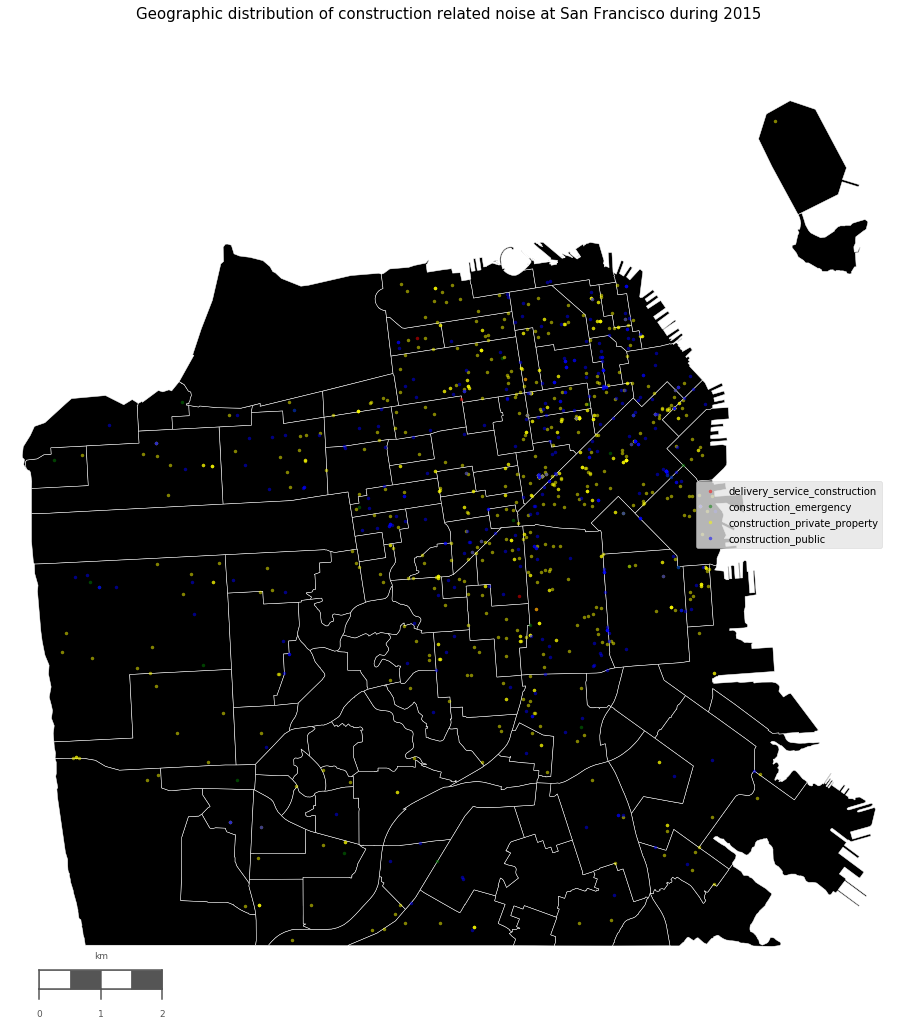

In [25]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
noise_colors=['red','green','yellow','blue']
# Scatter construction noise location
for i in range(len(construction_type)):
    j=makePoints(construction_noise[construction_noise["Type"]==construction_type[i]])
    dev = m.scatter(
    [geom.x for geom in j],
    [geom.y for geom in j],
    10, marker='o', lw=.25,
    facecolor=noise_colors[i], edgecolor=noise_colors[i],
    alpha=0.5, antialiased=True,
    label=construction_type[i], zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of construction related noise at San Francisco during 2015", size=15)
fig.set_size_inches(15,15)
plt.show()

Use the necessary plot needed files got before, and draw the scatter plot of music related noise.

D:\anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3274: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3283: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for mo

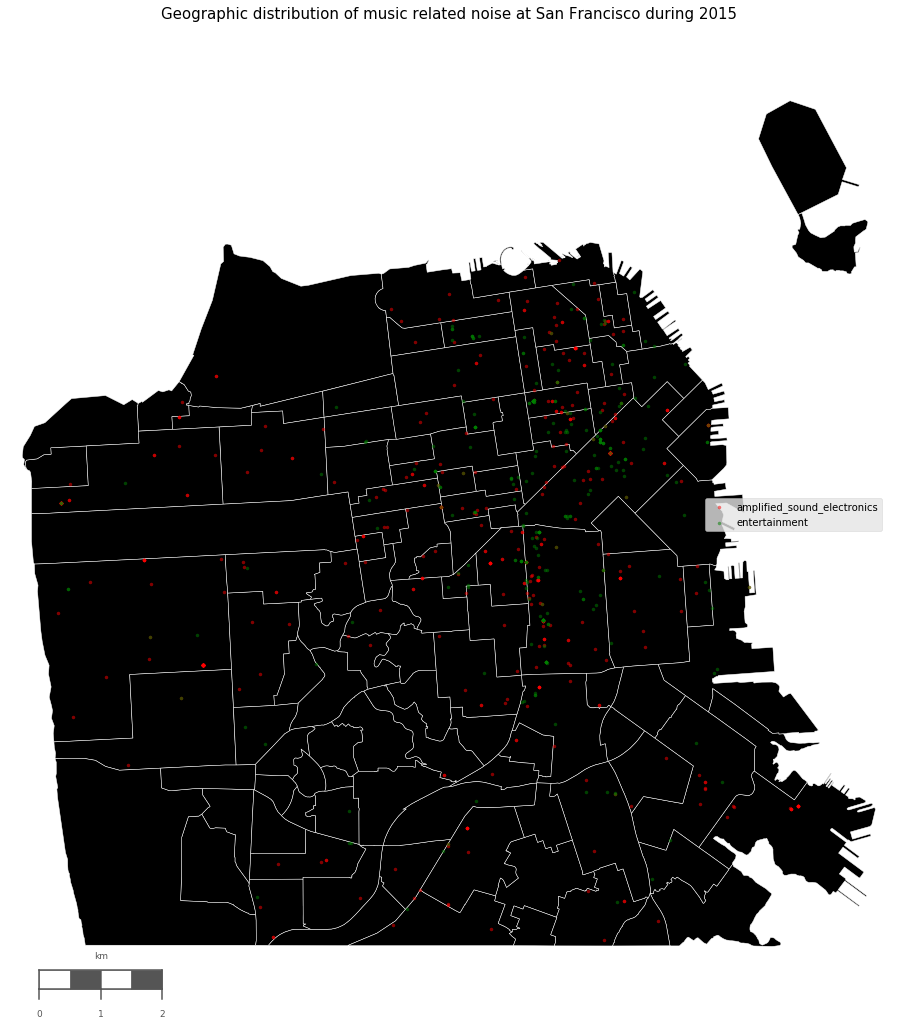

In [26]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
music_colors=['red','green']#,'yellow','blue']
# Scatter construction noise location
entertain=['amplified_sound_electronics','entertainment']
for i in range(2):
    j=makePoints(noise[noise["Type"]==entertain[i]]) 
    dev = m.scatter(
    [geom.x for geom in j],
    [geom.y for geom in j],
    10, marker='o', lw=.25,
    facecolor=noise_colors[i], edgecolor=noise_colors[i],
    alpha=0.5, antialiased=True,
    label=entertain[i], zorder=3)

ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of music related noise at San Francisco during 2015", size=15)
fig.set_size_inches(15,15)
plt.show()

__Exercise 1.2.4__ In this question, I tried to find the best times and places to find food trucks. Firstly, I got all dataframe of food truck schdule and food truck locations. Then I merge them by locationid which give me the new dataframe file. Then I group the file by Address, StartHour and EndHour, then count the total number of trucks appeared in each location time combination. The answer shows that the best place and time to find a food truck is at **1 SANSOME Street, SUTTER Street to BUSH Street (1 - 99), from 11:00am to 15:00pm**. At this location and time range, food trucks have gone to this place 15 times. In order to visulize this answer, I draw the point with red color on the San Francisco map, and the answer shows that this location locate in the downtown area. This answer definitely make sense, since downtown area is crowded with people which means the customer market is huge, many people might bought cheap food from food trucks when they are tired of shopping. Accordingly, when you go to San Francisco, and you want to find a food truck to buy foods, just go to 1 SANSOME Street, which has the highest probability with food truck waiting for you. Lastly, I tried to find the best location-time combination for each day of week, but when I count the data grouped by address, time, and dayofweek, each data set have only one document except 1 SANSOME Street, so there are no enough information to find the best time-location combination for each day of week.

Read all data from mobile food schedule and location SQL

In [27]:
#get the schedule dataframe
sql_query = """
select * from mobile_food_schedule
"""
schedule = pd.read_sql_query(sql_query,sfdata)

In [28]:
#get the location dataframe
sql_query = """
select * from mobile_food_locations
"""
location = pd.read_sql_query(sql_query,sfdata)
location=location.dropna()

Group by location, start hour and end hour, and count the number of data for each group, I can find the hotest location and time range. Which shows that **1 SANSOME ST** is the one we want. 

In [29]:
#find the time and location where has highest number of appearance of food trucks
schedule_location = pd.merge(location,schedule,left_on='locationid',right_on='locationid',how='inner')
grouped_schedule_location = schedule_location.groupby(['Address','StartHour','EndHour']).count()
loca_time = grouped_schedule_location[grouped_schedule_location['locationid']==max(grouped_schedule_location.locationid.values)]
loca_time

,,,locationid,LocationDescription,Latitude,Longitude,permit,DayOfWeek
Address,StartHour,EndHour,,,,,,
1 SANSOME ST,11,15,15,15,15,15,15,15


In [30]:
#show all the data in the hottest time and location 
schedule_location[(schedule_location['Address']=='1 SANSOME ST')&(schedule_location['StartHour']==11)&(schedule_location['EndHour']==15)]

,locationid,LocationDescription,Address,Latitude,Longitude,permit,DayOfWeek,EndHour,StartHour
836,762513,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,16MFF-0032,Mo,15,11
837,762513,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,16MFF-0032,Tu,15,11
838,762513,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,16MFF-0032,We,15,11
839,762513,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,16MFF-0032,Th,15,11
840,762513,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,16MFF-0032,Fr,15,11
2162,934719,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,17MFF-0122,Mo,15,11
2163,934719,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,17MFF-0122,Tu,15,11
2164,934719,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,17MFF-0122,We,15,11
2165,934719,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,17MFF-0122,Th,15,11
2166,934719,SANSOME ST: SUTTER ST to BUSH ST (1 - 99),1 SANSOME ST,37.790485,-122.40094,17MFF-0122,Fr,15,11


Using the longitude data and Latitude data in shedule dataset, and draw the point on SF shapefile map.

D:\anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\anaconda\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The is

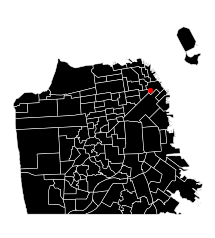

In [32]:
#draw the location of best place on map
point=schedule_location[(schedule_location['Address']=='1 SANSOME ST')&(schedule_location['StartHour']==11)&(schedule_location['EndHour']==15)]
point['Lon']=point['Longitude']
point['Lat']=point['Latitude']
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
j=makePoints(point) 
dev = m.scatter(j[0].x,j[0].y,20, marker='o', lw=.75,
facecolor='red', edgecolor='red', antialiased=True, zorder=3)
plt.show()

__Exercise 1.2.5__ In this question, I try to find the relationship between housing prices and other tables like crime, parks, parking lot and school. Firstly, I extract price table and calculate the average median sold price per square feet for each zipcode area. Then by merging with San Francisco shapefile with ke--zipcode, I got the polygon area for each zipcode. Consequencely, since all the other tables have longitude and latitude data, I can group the location of different data by zipcode area and count the number. After that, I do the linear fit between house price and other tables, and believe the trend of fit line will show me whether these two data are positive related or negtive related, and the summary table are listed below.


|  | slope | intercept | r_value | p_value | std_er |
| ------| ------ | ------ |------ |------ |------ |
| parks | -0.009 | 12.66 | -0.196 | 0.347 | 0.010 |
| parking lot | 0.043 | 27.409 | 0.138 | 0.510 |0.065|
| school | -0.013 | 23.467 | -0.157 | 0.453 | 0.017 |
| crime | 5.029 | 3295.38 | 0.112 | 0.595 | 9.319 |

The linear fit show that, the price of parks and house price are negtive related, and I believe the reason is park must locate away from downtown, otherwise it will be too costly. Accordingly, people live beside park might have a life which is not convenience, so the price of house is negtive related to park numbers. In addition, the parking lot are positive related to house price. I believe the richer people who can afford high price house will live near downtown where need a lot of parking lots. For the negtive relation between school number and house price, this might share a similar reason like park, which are costly to be built near downtown. Surprisingly, crime number seems to be positive related to house price, and people might think that more expensive house might be more safe, but the problem is thefts prefer to break in rich people's house as well. On the other hand, the distribution of crime seems like a normal distribution, so the linear fit is not a good way for correlation analysis between crime and house price.

Get parks, parking and school table from SQL

In [33]:
#read dategrame from parks ,parking and schools table
sql_query = """
select * from parks
"""
park = pd.read_sql_query(sql_query,sfdata)

In [34]:
sql_query = """
select * from parking
"""
parking = pd.read_sql_query(sql_query,sfdata)

In [35]:
sql_query = """
select * from schools
"""
school = pd.read_sql_query(sql_query,sfdata)

Draw another `basemap` by reading in US shapefile, then extract all `polygon` files.

,ZCTA5CE10,poly
0,36907,"POLYGON ((3280890.739876465 -48989.4783890652,..."
1,85922,POLYGON ((1228195.541028868 -369302.5392130821...
2,84536,"POLYGON ((1048883.680300432 11231.40043248014,..."
3,94929,POLYGON ((-39265.78567160383 60055.21410220598...
4,94929,POLYGON ((-40010.70081912437 63665.22862338351...


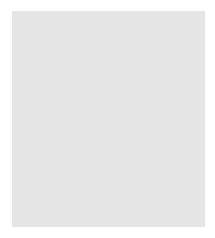

In [37]:
k = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
k.readshapefile(
    'cb_2015_us_zcta510_500k',
    'US',
    color='none',
    zorder=2)
df_kmap = pd.DataFrame({
    'poly': [Polygon(xy) for xy in k.US],
    'ZCTA5CE10': [ward['ZCTA5CE10'] for ward in k.US_info]})
df_kmap.head()

Group price data according to `zipcodes`, and calculate mean price in each zipcode area. Extracting all `polygon` data in California, which has zipcodes from 90000 to 96199. After that, we can merge these two dataframe with zipcodes.

In [38]:
#find the mean price for each california polygon area and change regionname to str in order for latter merging
price['RegionName']=price['RegionName'].astype(str)
mean_price = price.groupby('RegionName').mean()
df_kmap = df_kmap[df_kmap.ZCTA5CE10.str.startswith("9")]
df_kmap = df_kmap[pd.to_numeric(df_kmap.ZCTA5CE10) <= 96199]

In [39]:
df_kmap_price = pd.merge(mean_price,df_kmap,left_index=True,right_on='ZCTA5CE10',how='inner')
df_kmap_price

,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes,ZCTA5CE10,poly
32393,2.172000,375.629802,18.342105,4.413822,94080,POLYGON ((4159.011197325715 -5452.628079228918...
32412,3.984933,626.417276,16.411053,6.538972,94102,"POLYGON ((7672.722961205203 8682.863844817697,..."
12574,3.679040,604.009929,17.654868,7.188214,94103,"POLYGON ((7975.897557134769 7335.658411668751,..."
7072,NaN,1336.128581,NaN,14.831512,94104,"POLYGON ((9910.512479627789 10410.62179961561,..."
32413,4.279173,798.257824,20.133816,6.928359,94105,"POLYGON ((10009.64690028015 9767.641706174742,..."
13388,3.665093,592.651062,19.067105,7.049942,94107,"POLYGON ((9854.587410318658 7198.999294774334,..."
1371,4.149920,501.013201,18.649474,6.620130,94108,"POLYGON ((9011.66583455111 10572.50738911045, ..."
32414,3.852080,618.325709,19.251316,6.579195,94109,"POLYGON ((7456.197436451825 12077.11270651274,..."
8337,3.145520,543.998864,21.088947,5.126783,94110,"POLYGON ((7934.22604954194 4071.267659231718, ..."
32415,3.669520,445.680441,19.746184,6.521255,94111,"POLYGON ((9824.696259623917 11866.03346471357,..."


Using dataframe from parks, parking lot ,school and crime, I calculate the number of parks, parking lots, schools and crimes in different San Francisco neighbour. Then I draw the scatter plot between home price and other dataframe, and plot the linear fit linear to find out whether there are correlations between price and other data.  

In [40]:
#count the number of crime, park, parking lot and school in each polygon area
#drop the highest house price since it's far away from others
park_points=makePoints(park)
parking_points=makePoints(parking)
school_points=makePoints(school)
df_kmap_price['park_count'] = df_kmap_price['poly'].map(lambda x: int( len(list(filter(prep(x).contains, park_points)))))
df_kmap_price['parking_count'] = df_kmap_price['poly'].map(lambda x: int( len(list(filter(prep(x).contains, parking_points)))))
df_kmap_price['school_count'] = df_kmap_price['poly'].map(lambda x: int( len(list(filter(prep(x).contains, school_points)))))
df_kmap_price['crime_count'] = df_kmap_price['poly'].map(lambda x: int( len(list(filter(prep(x).contains, sf_15_crimes_points)))))
df_kmap_price=df_kmap_price.dropna()
df_kmap_price

,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes,ZCTA5CE10,poly,park_count,parking_count,school_count,crime_count
32393,2.172000,375.629802,18.342105,4.413822,94080,POLYGON ((4159.011197325715 -5452.628079228918...,0,0,0,0
32412,3.984933,626.417276,16.411053,6.538972,94102,"POLYGON ((7672.722961205203 8682.863844817697,...",11,78,23,15824
12574,3.679040,604.009929,17.654868,7.188214,94103,"POLYGON ((7975.897557134769 7335.658411668751,...",5,165,15,24596
32413,4.279173,798.257824,20.133816,6.928359,94105,"POLYGON ((10009.64690028015 9767.641706174742,...",0,75,6,3044
13388,3.665093,592.651062,19.067105,7.049942,94107,"POLYGON ((9854.587410318658 7198.999294774334,...",5,116,19,7522
1371,4.149920,501.013201,18.649474,6.620130,94108,"POLYGON ((9011.66583455111 10572.50738911045, ...",4,21,12,3362
32414,3.852080,618.325709,19.251316,6.579195,94109,"POLYGON ((7456.197436451825 12077.11270651274,...",11,68,12,11293
8337,3.145520,543.998864,21.088947,5.126783,94110,"POLYGON ((7934.22604954194 4071.267659231718, ...",24,98,42,14159
32415,3.669520,445.680441,19.746184,6.521255,94111,"POLYGON ((9824.696259623917 11866.03346471357,...",3,49,2,2791
37135,2.466640,416.744886,17.992895,3.745187,94112,"POLYGON ((4458.050345630996 1177.780289090536,...",10,49,24,7437


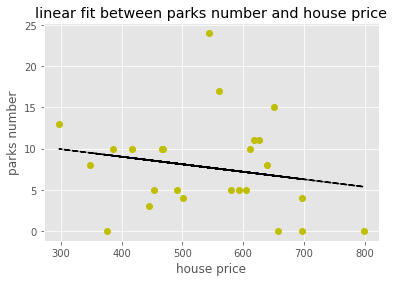

slope:-0.009137598535388636
intercept:12.661974307303126
r_value:-0.1964448116871396
p_value:0.3466266367077172
std_err:0.00951002770664765


In [42]:
import scipy
from scipy import stats
from sklearn import datasets, linear_model
x = df_kmap_price['MedianSoldPricePerSqft_AllHomes'].values
y = df_kmap_price['park_count'].values
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.title('linear fit between parks number and house price')
plt.xlabel('house price')
plt.ylabel('parks number')
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
print('slope:{}\nintercept:{}\nr_value:{}\np_value:{}\nstd_err:{}'.format(slope, intercept, r_value, p_value, std_err))

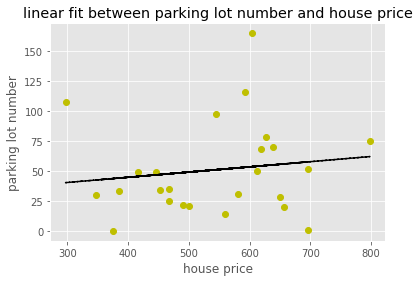

slope:0.04339672300222316
intercept:27.409337629844135
r_value:0.13812106170394647
p_value:0.51027081871319
std_err:0.06488592111331358


In [43]:
x = df_kmap_price['MedianSoldPricePerSqft_AllHomes'].values
y = df_kmap_price['parking_count'].values
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.title('linear fit between parking lot number and house price')
plt.xlabel('house price')
plt.ylabel('parking lot number')
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
print('slope:{}\nintercept:{}\nr_value:{}\np_value:{}\nstd_err:{}'.format(slope, intercept, r_value, p_value, std_err))

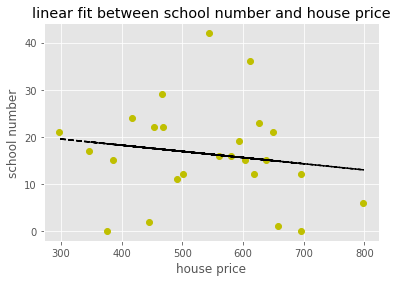

slope:-0.013140801189059114
intercept:23.46706446581114
r_value:-0.1573282806913784
p_value:0.4526138306543215
std_err:0.017199214881295985


In [44]:
x = df_kmap_price['MedianSoldPricePerSqft_AllHomes'].values
y = df_kmap_price['school_count'].values
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.title('linear fit between school number and house price')
plt.xlabel('house price')
plt.ylabel('school number')
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
print('slope:{}\nintercept:{}\nr_value:{}\np_value:{}\nstd_err:{}'.format(slope, intercept, r_value, p_value, std_err))

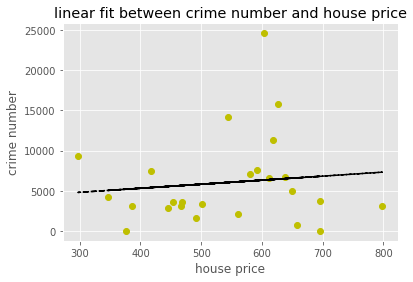

slope:5.028662994157868
intercept:3295.3803742211117
r_value:0.11180133031941755
p_value:0.5946840459442667
std_err:9.319879475577013


In [45]:
x = df_kmap_price['MedianSoldPricePerSqft_AllHomes'].values
y = df_kmap_price['crime_count'].values
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.title('linear fit between crime number and house price')
plt.xlabel('house price')
plt.ylabel('crime number')
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
print('slope:{}\nintercept:{}\nr_value:{}\np_value:{}\nstd_err:{}'.format(slope, intercept, r_value, p_value, std_err))